# Walmart Sales Prediction


In [15]:
# Import Relevent Packages

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import prophet
import time
import warnings
from itertools import cycle
from sklearn.svm import SVR
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [16]:
import lightgbm as lgb

OSError: dlopen(/Users/willchien/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/willchien/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [19]:
!pip uninstall lightgbm

Found existing installation: lightgbm 3.2.1
Uninstalling lightgbm-3.2.1:
  Would remove:
    /Users/willchien/opt/anaconda3/lib/python3.8/site-packages/lightgbm-3.2.1.dist-info/*
    /Users/willchien/opt/anaconda3/lib/python3.8/site-packages/lightgbm/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user


In [20]:
%matplotlib inline
plt.style.use('bmh')
sns.set_style("darkgrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# 1. Data Preprocessing 
Including: 
- Transform the wide format to long format
- Aggregate all the relevent data into one dataframe

In [25]:
os.chdir("../data") 

# Read in data
tra = pd.read_csv('sales_train_validation_afcs2020.csv')
val = pd.read_csv('sales_train_evaluation_afcs2020.csv')
cal = pd.read_csv('calendar_afcs2020.csv')
price = pd.read_csv('sell_prices_afcs2020.csv')

In [27]:
for i in range(28):
    val[f"d_{1942+i}"] = 0
    
val.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,...,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_2_001_CA_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
# Melt it to the long fromat 

days = val.columns[1:]

long_format = pd.melt(val, id_vars="id", value_vars=days, var_name="day", value_name="demand")
long_format.tail()

,id,day,demand
293376,HOBBIES_2_145_CA_3_validation,d_1969,0
293377,HOBBIES_2_146_CA_3_validation,d_1969,0
293378,HOBBIES_2_147_CA_3_validation,d_1969,0
293379,HOBBIES_2_148_CA_3_validation,d_1969,0
293380,HOBBIES_2_149_CA_3_validation,d_1969,0


In [29]:
# Map it with date from calendar

data = pd.merge(long_format, cal, left_on= 'day', right_on = 'd')
data = data.drop("d", axis = 1)
data['date'] = pd.to_datetime(data['date'])
data["map"] = data["id"] + "_" + data["wm_yr_wk"].astype(str)
data.tail()

,id,day,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,map
293376,HOBBIES_2_145_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_145_CA_3_validation_11621
293377,HOBBIES_2_146_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_146_CA_3_validation_11621
293378,HOBBIES_2_147_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_147_CA_3_validation_11621
293379,HOBBIES_2_148_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_148_CA_3_validation_11621
293380,HOBBIES_2_149_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_149_CA_3_validation_11621


In [30]:
# Map it with price 

price["map"] = price["item_id"] + "_"+ price["store_id"] + "_validation_" +price["wm_yr_wk"].astype(str)
data2 = pd.merge(data, price, left_on="map", right_on="map")
data2 = data2.drop(["map", "store_id", "wm_yr_wk_y"], axis = 1)
data2.tail()

,id,day,demand,date,wm_yr_wk_x,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,item_id,sell_price
226736,HOBBIES_2_147_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_147,0.97
226737,HOBBIES_2_148_CA_3_validation,d_1968,0,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,HOBBIES_2_148,0.88
226738,HOBBIES_2_148_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_148,0.88
226739,HOBBIES_2_149_CA_3_validation,d_1968,0,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,HOBBIES_2_149,0.97
226740,HOBBIES_2_149_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_149,0.97


# 2. Exploratory Data Analysis
Firstly, checking indiviudual items to examine any consistent seasonal pattern exist. After that, aggreagting all the demands together and check seasoal pattern again. Also we try to explore other features including sell price and event for further insights.

## 2.1 Individual Demand

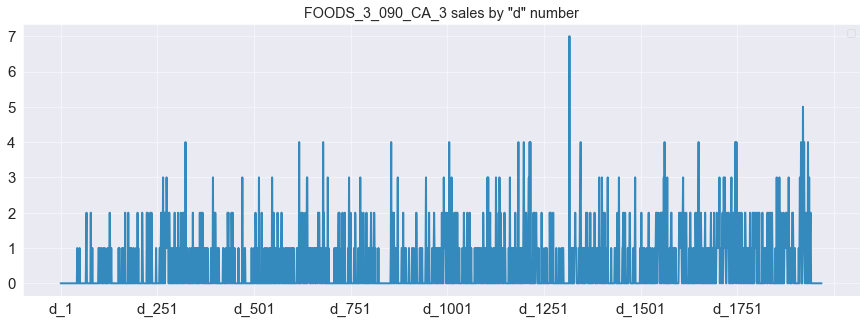

In [31]:
d_cols = [c for c in val.columns if 'd_' in c] # sales data columns

val.loc[val['id'] == 'HOBBIES_2_003_CA_3_validation'].set_index('id')[d_cols].T.plot(figsize=(15, 5),
                                                                                   title='FOODS_3_090_CA_3 sales by "d" number',
                                                                                   color=next(color_cycle))
plt.legend('')
plt.show()

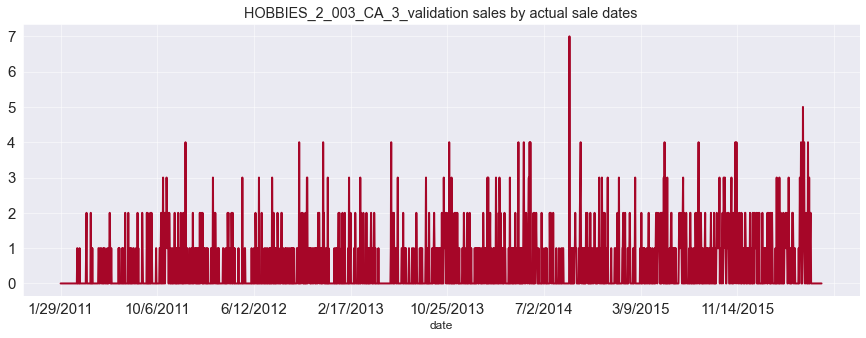

In [32]:
# Merge calendar on our items' data
example = val.loc[val['id'] == 'HOBBIES_2_003_CA_3_validation'][d_cols].T
example = example.rename(columns={2:'HOBBIES_2_003_CA_3_validation'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['HOBBIES_2_003_CA_3_validation'].plot(figsize=(15, 5),
                                                                color=next(color_cycle),
                                                                title='HOBBIES_2_003_CA_3_validation sales by actual sale dates')
plt.show()

In [33]:
example2 = val.loc[val['id'] == 'HOBBIES_2_004_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={3:'HOBBIES_2_004_CA_3_validation'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(cal, how='left', validate='1:1')
 
example3 = val.loc[val['id'] == 'HOBBIES_2_005_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={4:'HOBBIES_2_005_CA_3_validation'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(cal, how='left', validate='1:1')

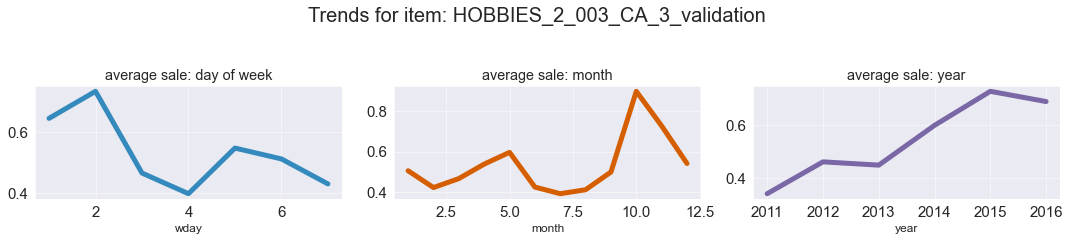

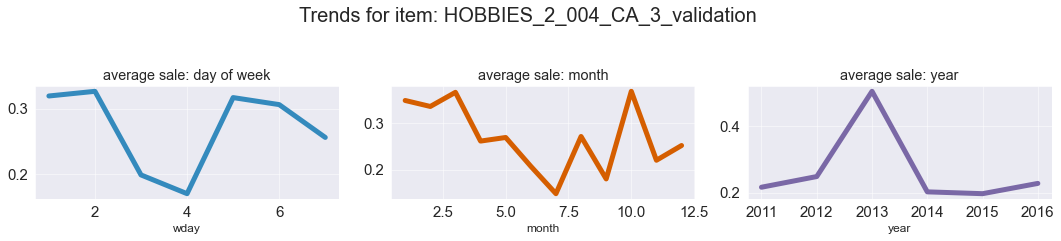

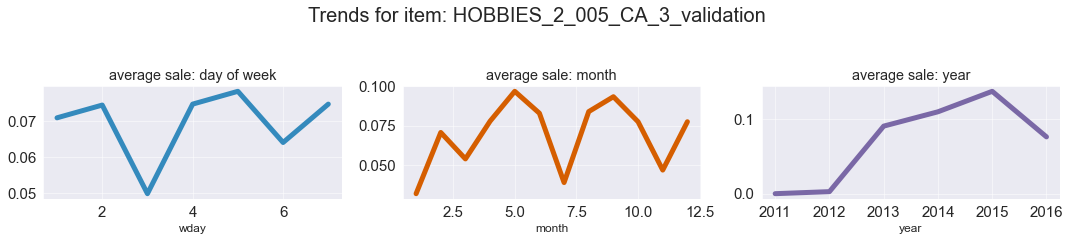

In [34]:
examples = ['HOBBIES_2_003_CA_3_validation','HOBBIES_2_004_CA_3_validation','HOBBIES_2_005_CA_3_validation']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],
 
              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
 
              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()


In [35]:
twenty_examples = val.sample(20, random_state=529).set_index('id')[d_cols].T.merge(cal.set_index('d')['date'],
                                                                                   left_index=True,
                                                                                   right_index=True,
                                                                                   validate='1:1').set_index('date')

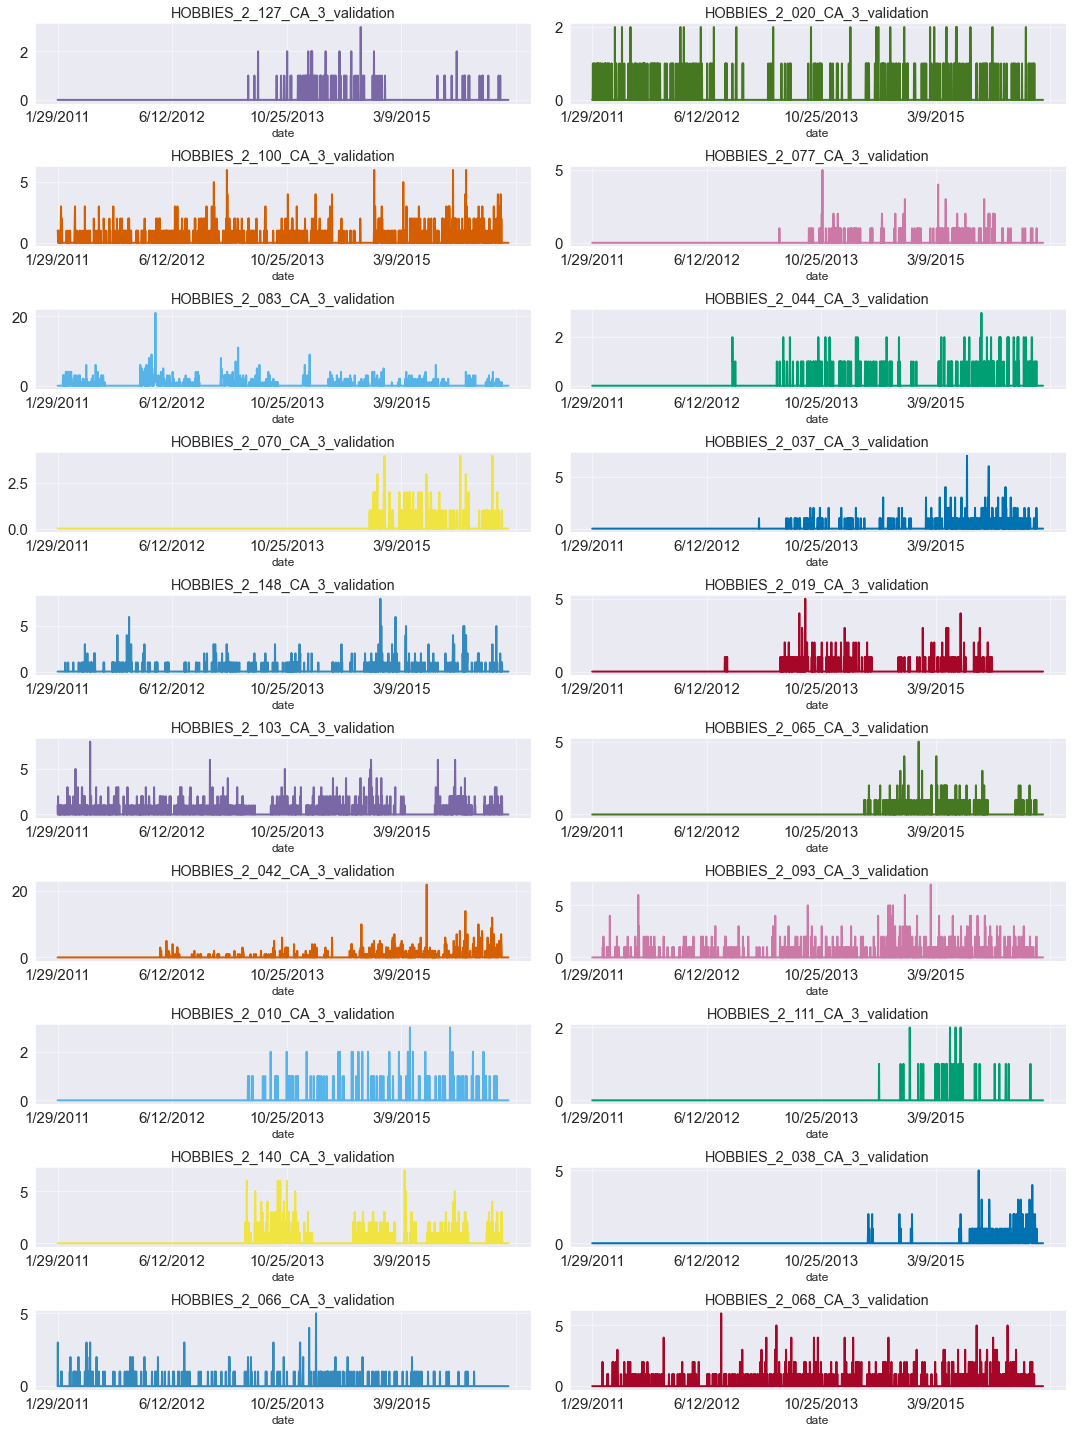

In [36]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

## 2.2 Overall demands

In [42]:
data2

,id,day,demand,date,wm_yr_wk_x,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,item_id,sell_price
0,HOBBIES_2_002_CA_3_validation,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,HOBBIES_2_002,1.97
1,HOBBIES_2_002_CA_3_validation,d_2,0,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,HOBBIES_2_002,1.97
2,HOBBIES_2_002_CA_3_validation,d_3,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,HOBBIES_2_002,1.97
3,HOBBIES_2_002_CA_3_validation,d_4,1,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,HOBBIES_2_002,1.97
4,HOBBIES_2_002_CA_3_validation,d_5,0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,HOBBIES_2_002,1.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226736,HOBBIES_2_147_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_147,0.97
226737,HOBBIES_2_148_CA_3_validation,d_1968,0,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,HOBBIES_2_148,0.88
226738,HOBBIES_2_148_CA_3_validation,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,HOBBIES_2_148,0.88
226739,HOBBIES_2_149_CA_3_validation,d_1968,0,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,HOBBIES_2_149,0.97


KeyError: 'date'

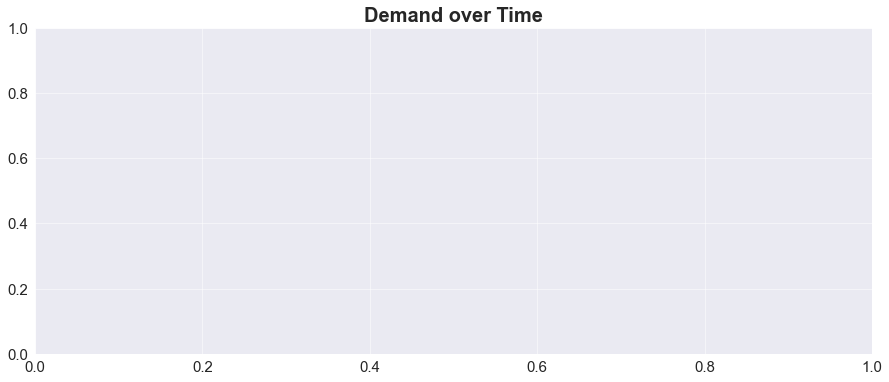

In [38]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Demand over Time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
tra.plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax)

In [118]:
d = pd.DataFrame(data2.groupby(["year", "month", "wday", "date", "day"]).sum().demand).reset_index()
d.head()

,year,month,wday,date,day,demand
0,2011,1,1,2011-01-29,d_1,19
1,2011,1,2,2011-01-30,d_2,29
2,2011,1,3,2011-01-31,d_3,24
3,2011,2,1,2011-02-05,d_8,17
4,2011,2,1,2011-02-12,d_15,22


NameError: name 'd' is not defined

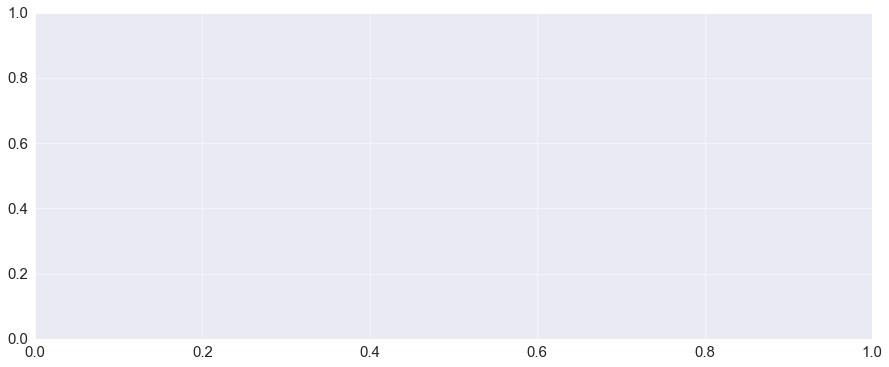

In [40]:
variable = 'demand'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("colorblind", 6)
sns.lineplot(d['month'], d[variable], hue=d['year'], palette=palette)
ax.set_title('Seasonal plot of demand', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Demand', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Demand')

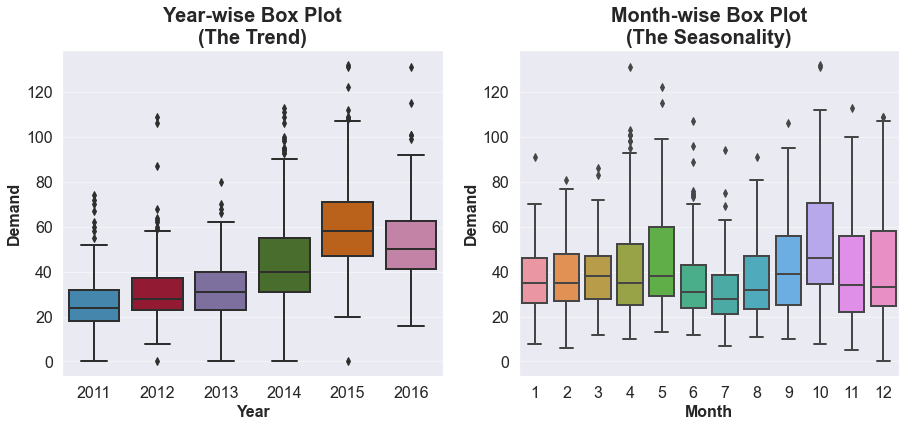

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(d['year'], d[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Demand', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(d['month'], d[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Demand', fontsize = 16, fontdict=dict(weight='bold'))

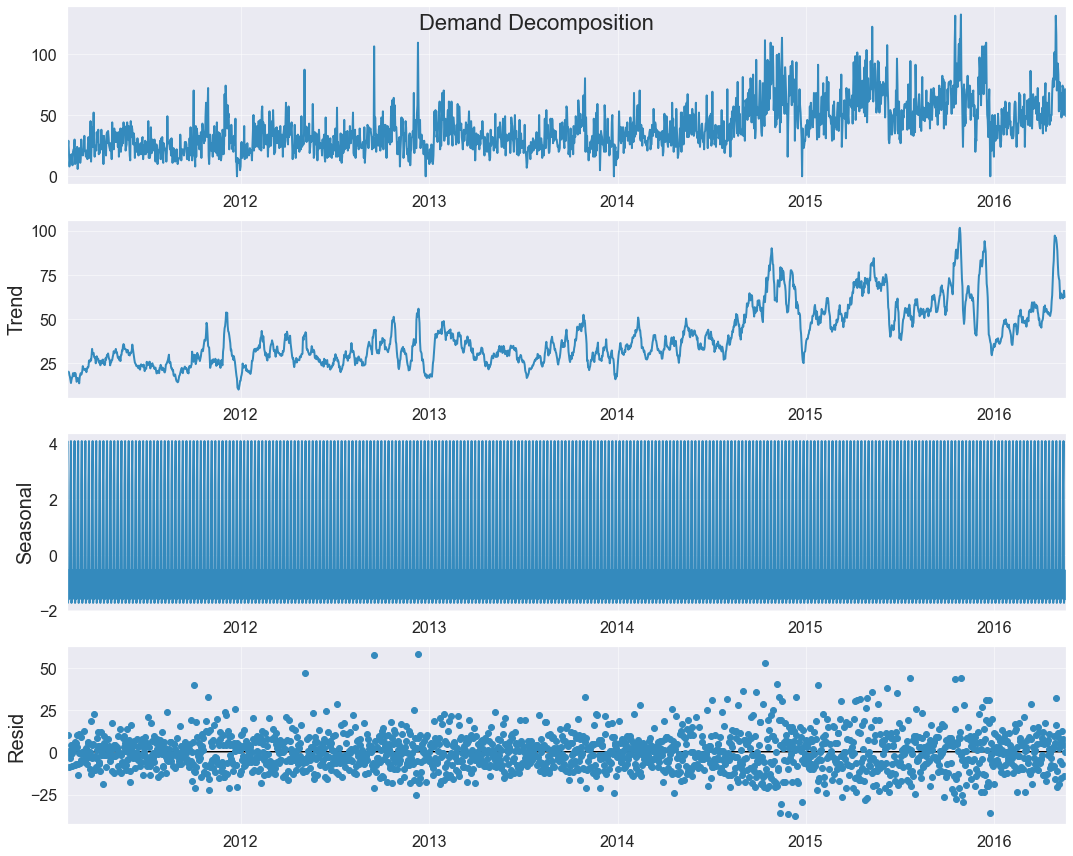

In [119]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

y = d[['date','demand']].set_index('date')
y = y.asfreq('d')
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomp = decomposition.plot()
decomp.suptitle('Demand Decomposition', fontsize=22);

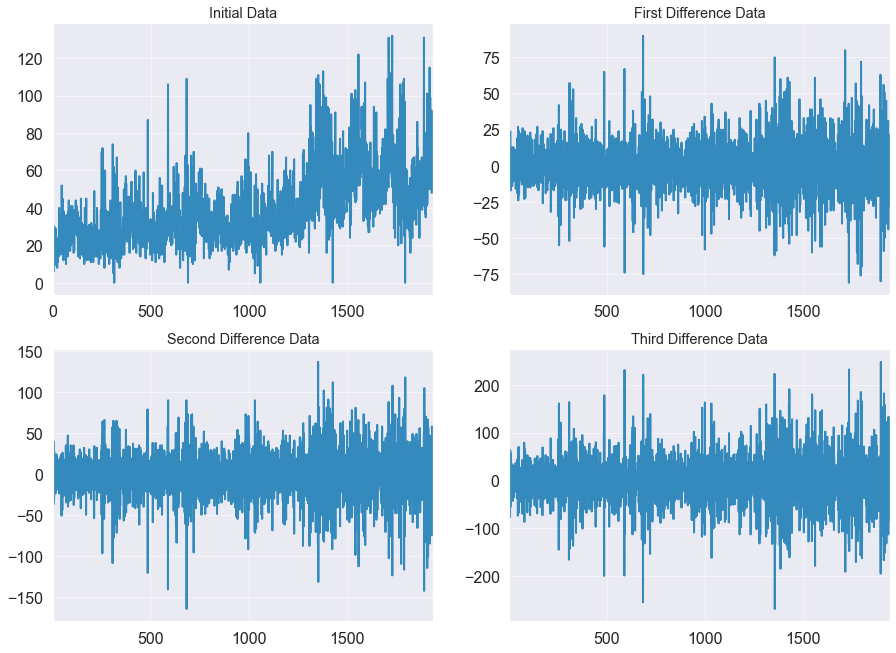

In [120]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

d['demand_Diff1'] = diff(d['demand'],k_diff=1)
d['demand_Diff2'] = diff(d['demand'],k_diff=2)
d['demand_Diff3'] = diff(d['demand'],k_diff=3)

d['demand'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
d['demand_Diff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
d['demand_Diff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
d['demand_Diff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

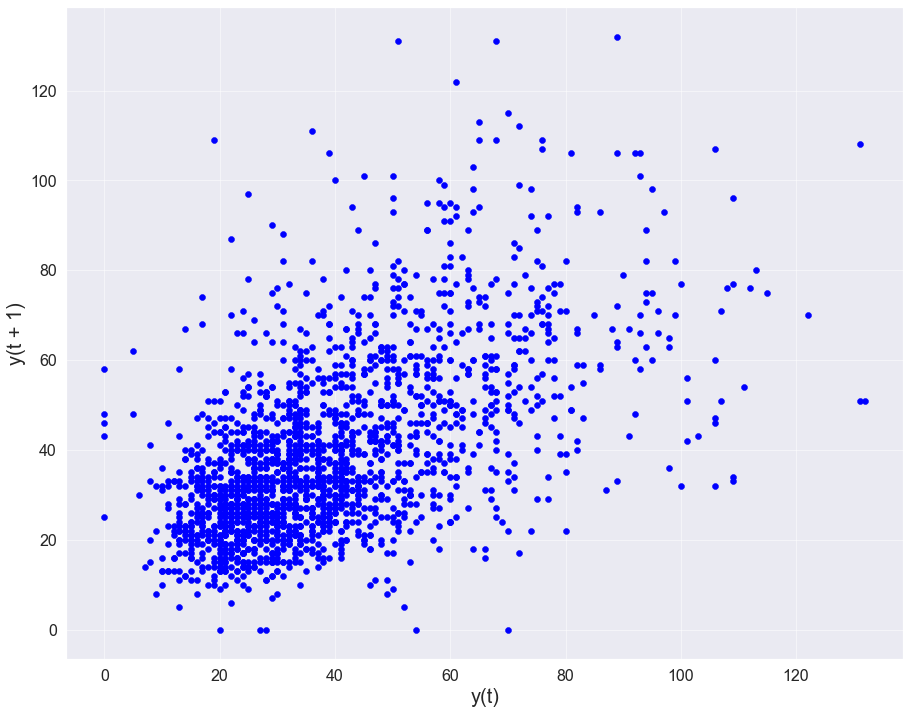

In [134]:
from pandas.plotting import lag_plot

lag_plot(d['demand'])

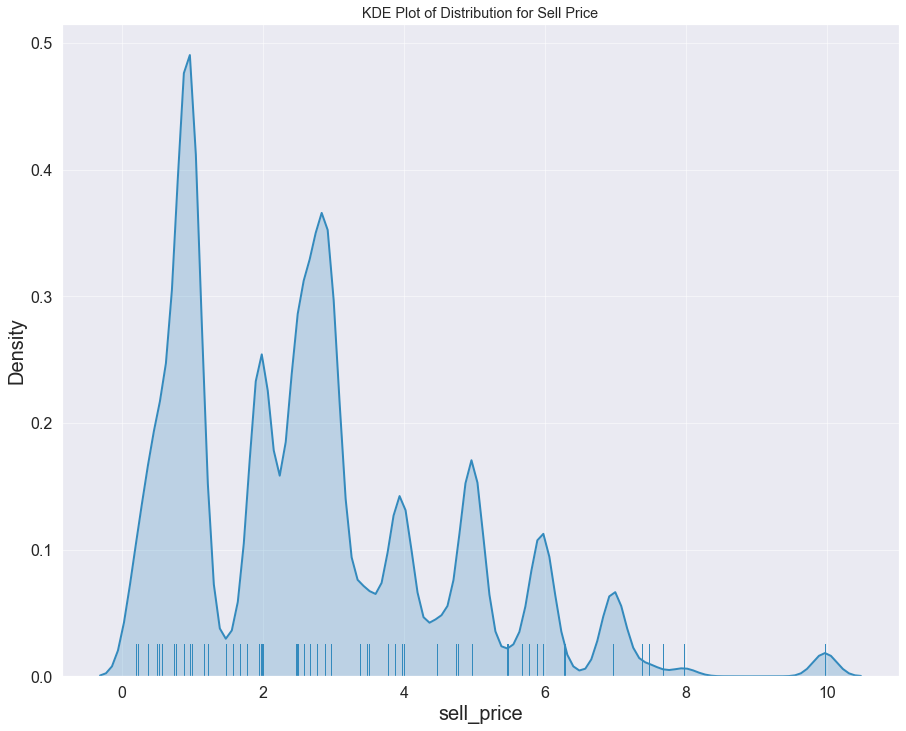

In [224]:
sns.distplot(data2['sell_price'],bins=2,hist=False,rug=True,norm_hist=True,kde_kws={'shade':True})
plt.title('KDE Plot of Distribution for Sell Price')
plt.ylabel('Density')
plt.show()

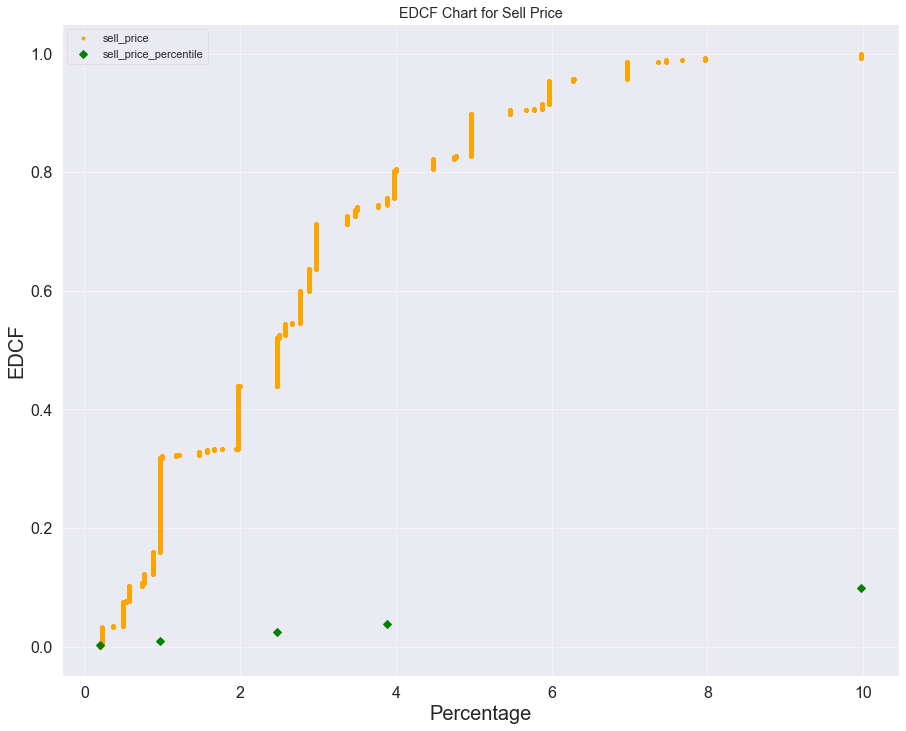

In [225]:

x = np.sort(data2['sell_price'])
y = np.arange(1,len(x)+1) / len(x)

percentile = np.array([0,25,50,75,100])
x_percent = np.percentile(x,q=percentile)

plt.plot(x,y,marker='.',linestyle='none',color='orange')
plt.plot(x_percent,x_percent/100,marker='D',linestyle='none',color='green')
plt.title('EDCF Chart for Sell Price')
plt.xlabel('Percentage')
plt.ylabel('EDCF')
plt.legend(('sell_price','sell_price_percentile'))
plt.show()

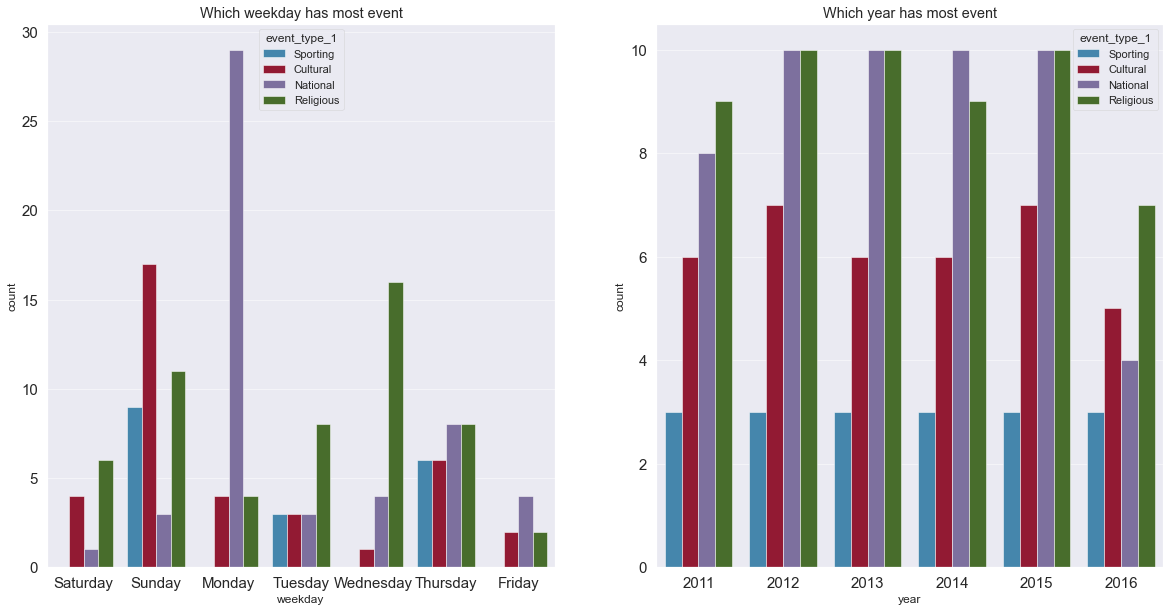

In [270]:
fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
sns.countplot(x='weekday', data=cal, hue = 'event_type_1',ax=ax0)
sns.countplot(x='year',data=cal, hue = 'event_type_1',ax=ax1)

ax0.set_title('Which weekday has most event')
ax1.set_title('Which year has most event')
plt.show()

In [430]:
data2.head()

,id,day,demand,date,wm_yr_wk_x,wday,month,year,event_type_1,event_type_2,snap_CA,sell_price,lag_7,rmean_7_7,demand_month_mean,demand_month_max,demand_month_min,demandmonth_max_to_min_diff,demand_dayofweek_mean,demand_dayofweek_median,demand_dayofweek_max
0,HOBBIES_2_002_CA_3_validation,1,0,2011-01-29,11101,1,1,2011,0,0,0,1.97,NaN,NaN,0.151899,2.0,0.0,2.0,0.169065,0.0,4.0
1,HOBBIES_2_002_CA_3_validation,2,0,2011-01-30,11101,2,1,2011,0,0,0,1.97,NaN,NaN,0.151899,2.0,0.0,2.0,0.183453,0.0,2.0
2,HOBBIES_2_002_CA_3_validation,3,0,2011-01-31,11101,3,1,2011,0,0,0,1.97,NaN,NaN,0.151899,2.0,0.0,2.0,0.158845,0.0,4.0
3,HOBBIES_2_002_CA_3_validation,4,1,2011-02-01,11101,4,2,2011,0,0,1,1.97,NaN,NaN,0.200000,4.0,0.0,4.0,0.158845,0.0,2.0
4,HOBBIES_2_002_CA_3_validation,5,0,2011-02-02,11101,5,2,2011,0,0,1,1.97,NaN,NaN,0.200000,4.0,0.0,4.0,0.173285,0.0,4.0


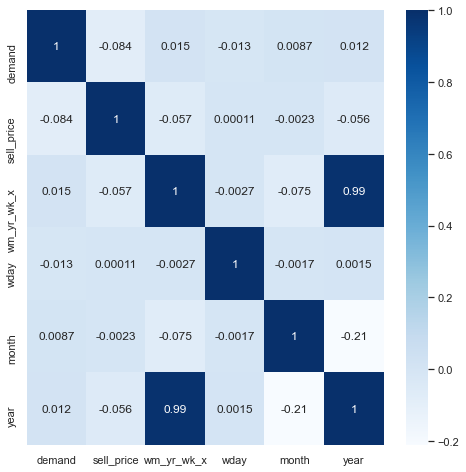

<Figure size 432x288 with 0 Axes>

In [35]:
# Draw heatmaps to inspect the correlations

def draw_corr_heatmap(dataframe, examine_list):

    corr = dataframe[examine_list].corr() 
    
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.heatmap(corr, cmap="Blues", annot=True, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    plt.show()
    
# Correlations in Numerical attributes 

exam_list = ["demand", 'sell_price', 'wm_yr_wk_x', 'weekday', 'wday', 'month','year', ]
draw_corr_heatmap(data2, exam_list)
plt.tight_layout()

# 3. Forecasting 
After visually exploring our datasets, it seems there is some seasonal pattern and correlations with different features for individual items, while an overal seasonal pattern or associations with respective features are not remarkable.

## 3.1 Forecas with Prophet

In [420]:
# Extract unique id names

tra = pd.read_csv('sales_train_validation_afcs2020.csv')
id_list = list(tra.id.unique())
id_list

['HOBBIES_2_001_CA_3_validation',
 'HOBBIES_2_002_CA_3_validation',
 'HOBBIES_2_003_CA_3_validation',
 'HOBBIES_2_004_CA_3_validation',
 'HOBBIES_2_005_CA_3_validation',
 'HOBBIES_2_006_CA_3_validation',
 'HOBBIES_2_007_CA_3_validation',
 'HOBBIES_2_008_CA_3_validation',
 'HOBBIES_2_009_CA_3_validation',
 'HOBBIES_2_010_CA_3_validation',
 'HOBBIES_2_011_CA_3_validation',
 'HOBBIES_2_012_CA_3_validation',
 'HOBBIES_2_013_CA_3_validation',
 'HOBBIES_2_014_CA_3_validation',
 'HOBBIES_2_015_CA_3_validation',
 'HOBBIES_2_016_CA_3_validation',
 'HOBBIES_2_017_CA_3_validation',
 'HOBBIES_2_018_CA_3_validation',
 'HOBBIES_2_019_CA_3_validation',
 'HOBBIES_2_020_CA_3_validation',
 'HOBBIES_2_021_CA_3_validation',
 'HOBBIES_2_022_CA_3_validation',
 'HOBBIES_2_023_CA_3_validation',
 'HOBBIES_2_024_CA_3_validation',
 'HOBBIES_2_025_CA_3_validation',
 'HOBBIES_2_026_CA_3_validation',
 'HOBBIES_2_027_CA_3_validation',
 'HOBBIES_2_028_CA_3_validation',
 'HOBBIES_2_029_CA_3_validation',
 'HOBBIES_2_03

In [549]:
# Create a for loop to run all the 149 items

result = pd.DataFrame()

for item in id_list:
    mini = data2[data2.id ==item][["date", "demand"]]
    mini.rename(columns={'date':'ds', 'demand':'y'}, inplace = True)

    m = Prophet(daily_seasonality=True)
    m.fit(mini)
    future = m.make_future_dataframe(periods=28, include_history=False)
    forecast = m.predict(future)[['ds', 'yhat']]
    forecast["id"] = item
    result = pd.concat([result, forecast])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [550]:
result.head()

,ds,yhat,id
0,2016-05-23,0.182209,HOBBIES_2_001_CA_3_validation
1,2016-05-24,0.159351,HOBBIES_2_001_CA_3_validation
2,2016-05-25,0.152445,HOBBIES_2_001_CA_3_validation
3,2016-05-26,0.161520,HOBBIES_2_001_CA_3_validation
4,2016-05-27,0.171917,HOBBIES_2_001_CA_3_validation


In [551]:
# Reframe it to the submission format

wide_format= result.pivot(index="id", columns="ds", values="yhat").reset_index()
wide_format = wide_format.rename_axis(None, axis=1)
wide_format.head()

,id,2016-05-23 00:00:00,2016-05-24 00:00:00,2016-05-25 00:00:00,2016-05-26 00:00:00,2016-05-27 00:00:00,2016-05-28 00:00:00,2016-05-29 00:00:00,2016-05-30 00:00:00,2016-05-31 00:00:00,2016-06-01 00:00:00,2016-06-02 00:00:00,2016-06-03 00:00:00,2016-06-04 00:00:00,2016-06-05 00:00:00,2016-06-06 00:00:00,2016-06-07 00:00:00,2016-06-08 00:00:00,2016-06-09 00:00:00,2016-06-10 00:00:00,2016-06-11 00:00:00,2016-06-12 00:00:00,2016-06-13 00:00:00,2016-06-14 00:00:00,2016-06-15 00:00:00,2016-06-16 00:00:00,2016-06-17 00:00:00,2016-06-18 00:00:00,2016-06-19 00:00:00
0,HOBBIES_2_001_CA_3_validation,0.182209,0.159351,0.152445,0.161520,0.171917,0.139311,0.192296,0.177702,0.163310,0.164359,0.180666,0.197384,0.170026,0.227058,0.215215,0.202225,0.203310,0.218313,0.232449,0.201332,0.253561,0.236038,0.216675,0.210907,0.218796,0.225786,0.187719,0.233418
1,HOBBIES_2_002_CA_3_validation,0.055962,0.050674,0.060315,0.055971,0.073707,0.043270,0.054452,0.026575,0.023939,0.036005,0.033875,0.053648,0.025112,0.038111,0.012024,0.011213,0.025194,0.025129,0.047161,0.021118,0.036870,0.013805,0.016281,0.033793,0.037462,0.063377,0.041294,0.060996
2,HOBBIES_2_003_CA_3_validation,0.863497,0.786289,0.933724,0.888929,0.795927,1.011135,1.094822,0.810532,0.732621,0.880220,0.836479,0.745418,0.963425,1.050713,0.770743,0.697764,0.850779,0.812790,0.727657,0.951597,1.044647,0.770094,0.702018,0.859263,0.824692,0.742043,0.967439,1.060852
3,HOBBIES_2_004_CA_3_validation,0.227341,0.209236,0.368000,0.365273,0.320866,0.389787,0.399788,0.270904,0.240483,0.386126,0.369705,0.311273,0.366088,0.362154,0.219755,0.176478,0.310151,0.282851,0.214814,0.261454,0.250900,0.103527,0.056981,0.189110,0.161981,0.095781,0.145846,0.140193
4,HOBBIES_2_005_CA_3_validation,0.172711,0.215173,0.225573,0.209146,0.229635,0.228134,0.237111,0.204146,0.243977,0.251265,0.231297,0.247879,0.242175,0.246729,0.209203,0.244417,0.247114,0.222663,0.234945,0.225192,0.226012,0.185116,0.217365,0.217533,0.191005,0.201667,0.190745,0.190829


In [552]:
wide_format.to_csv("sub_prophet.csv")

## 3.2 Using Machine Learing methods with feature engineering
As we know other attributes, including past order, promotional event, and sell price might influence demand. We start with feature engineering to complexify our models.

In [571]:
# Two major feautres regarding time sereis have been added to the model. 
# First, based on the insight acquiring from data vosualization, 
# we assume the demand for each item is autocorrelated to seven days ago. 
# Therefore, a lag of seven days in demand is added. 
# A second assumption is that a similar sales pattern could appear in both an annual and weekly basis. 
# We use a groupby method to
# add descroptice statiscs for each month and day of the week. 

def lags_windows(df):
    lags = [7]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","demand"]].groupby("id")["demand"].shift(lag)
        
    wins = [7]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())  
    return df

def per_timeframe_stats(df, col):
    months = df['month'].unique().tolist()
    for y in months:
        df.loc[df['month'] == y, col+'_month_mean'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['month'] == y, col+'_month_max'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
        df.loc[df['month'] == y, col+'_month_min'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.min()).astype("float32")
        df[col + 'month_max_to_min_diff'] = (df[col + '_month_max'] - df[col + '_month_min']).astype("float32")

    dayofweek = df['wday'].unique().tolist()

    for y in dayofweek:
        df.loc[df['wday'] == y, col+'_dayofweek_mean'] = df.loc[df['wday'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['wday'] == y, col+'_dayofweek_median'] = df.loc[df['wday'] == y].groupby(['id'])[col].transform(lambda x: x.median()).astype("float32")
        df.loc[df['wday'] == y, col+'_dayofweek_max'] = df.loc[df['wday'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
    
    return df

def feat_eng(df):
    df = lags_windows(df)
    df = per_timeframe_stats(df,'demand')
    
    return df

In [640]:
sub_final = pd.DataFrame()

for item_id in id_list:

    data002 = data2[data2.id ==item_id]
    data002['day'] = data002['day'].apply(lambda x: x.split('_')[1]).astype(int)
    data002 = data002.drop(['weekday', 'item_id'], axis = 1)
    data002 = data002.fillna('No')

    for c in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
        data002[c] = LabelEncoder().fit_transform(data002[c])

    train002 = data002[data002['date'] <= '2016-05-22']
    test002 = data002[(data002['date'] > '2016-05-6') & (data002['date'] <= '2016-06-19')]
    data_ml = feat_eng(train002)
    data_ml = data_ml.dropna()

    predictions = pd.DataFrame()
    predictions['date'] = test002['date']

    useless_cols = ['id','item_id','demand','date','weekday','demand_month_min', 'day']
    linreg_train_cols = ['sell_price','year','month','wday','lag_7','rmean_7_7']

    lgb_train_cols = data_ml.columns[~data_ml.columns.isin(useless_cols)]
    X_train = data_ml[lgb_train_cols].copy()
    y_train = data_ml["demand"]

    #Fit Linear Regression
    m_linreg = LinearRegression().fit(X_train[linreg_train_cols], 
                                      y_train)

    #Fit Random Forest
    m_rf = RandomForestRegressor(n_estimators=50,
                                 max_depth=5, 
                                 random_state=26, 
                                 n_jobs=-1).fit(X_train, y_train)
    
    #Fit Gradient Boositing 
    m_gb = GradientBoostingRegressor().fit(X_train, y_train)

    # Predict 
    fday = datetime(2016,5, 23) 
    max_lags = 15
    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        tst = test002[(test002.date >= day - timedelta(days=max_lags)) & (test002.date <= day)].copy()
        tst = feat_eng(tst)
        tst = tst.fillna(0)

        # Predict with Random Forest 
        tst_rf = tst.loc[tst.date == day , lgb_train_cols].copy()
        tst_rf = tst_rf.fillna(0) 
        test002.loc[test002.date == day, "preds_RandomForest"] = m_rf.predict(tst_rf)

        # Predict with Kinear Regression 
        tst_linreg = tst.loc[tst.date == day , linreg_train_cols].copy()
        tst_linreg = tst_linreg.fillna(0)    
        test002.loc[test002.date == day, "preds_LinearReg"] = m_linreg.predict(tst_linreg) 
        
        # Predict with Gradient Boosting 
        tst_gb = tst.loc[tst.date == day , lgb_train_cols].copy()
        tst_gb = tst_gb.fillna(0) 
        test002.loc[test002.date == day, "preds_GradeintBoosting"] = m_gb.predict(tst_gb)

    test_final = test002.loc[test002.date >= fday]
    sub_final = pd.concat([sub_final, test_final])

In [530]:
sub_final.tail()

,id,day,demand,date,wm_yr_wk_x,wday,month,year,event_type_1,event_type_2,snap_CA,sell_price,lag_7,rmean_7_7,demand_month_mean,demand_month_max,demand_month_min,demandmonth_max_to_min_diff,demand_dayofweek_mean,demand_dayofweek_median,demand_dayofweek_max,preds_LightGB,preds_RandomForest,preds_LinearReg
222268,HOBBIES_2_149_CA_3_validation,1937,0,2016-05-18,11616,5,5,2016,0,0,0,0.97,0.0,0.714286,0.202381,4.0,0.0,4.0,0.383117,0.0,11.0,0.144095,0.241933,0.566456
222269,HOBBIES_2_149_CA_3_validation,1938,1,2016-05-19,11616,6,5,2016,0,0,0,0.97,1.0,0.857143,0.202381,4.0,0.0,4.0,0.285714,0.0,8.0,0.274680,1.048518,0.636021
222270,HOBBIES_2_149_CA_3_validation,1939,2,2016-05-20,11616,7,5,2016,0,0,0,0.97,0.0,0.857143,0.202381,4.0,0.0,4.0,0.188312,0.0,6.0,0.433543,1.081815,0.562337
222567,HOBBIES_2_149_CA_3_validation,1940,0,2016-05-21,11617,1,5,2016,0,0,0,0.97,0.0,0.714286,0.202381,4.0,0.0,4.0,0.264516,0.0,3.0,0.329067,0.834186,0.587859
222568,HOBBIES_2_149_CA_3_validation,1941,0,2016-05-22,11617,2,5,2016,0,0,0,0.97,1.0,0.285714,0.202381,4.0,0.0,4.0,0.393548,0.0,5.0,0.562956,1.165523,0.631093


In [710]:
sub_final2.head()

,id,day,demand,date,wm_yr_wk_x,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,preds_GradeintBoosting_2
222273,HOBBIES_2_001_CA_3_validation,1942,0,2016-05-23,11617,3,5,2016,19,2,3,1,0,5.47,0.231458
222274,HOBBIES_2_001_CA_3_validation,1943,0,2016-05-24,11617,4,5,2016,19,2,3,1,0,5.47,0.229323
222275,HOBBIES_2_001_CA_3_validation,1944,0,2016-05-25,11617,5,5,2016,19,2,3,1,0,5.47,0.229323
222276,HOBBIES_2_001_CA_3_validation,1945,0,2016-05-26,11617,6,5,2016,19,2,3,1,0,5.47,0.182610
222277,HOBBIES_2_001_CA_3_validation,1946,0,2016-05-27,11617,7,5,2016,19,2,3,1,0,5.47,0.191849


In [659]:
# Reframe for submission  

linreg_final = sub_final[['id','date', 'preds_LinearReg']]
linreg_final= linreg_final.pivot(index="id", columns="date", values="preds_LinearReg").reset_index()
linreg_final = linreg_final.rename_axis(None, axis=1)
linreg_final.head()

linreg_final.to_csv('linreg_result.csv')

,id,2016-05-23 00:00:00,2016-05-24 00:00:00,2016-05-25 00:00:00,2016-05-26 00:00:00,2016-05-27 00:00:00,2016-05-28 00:00:00,2016-05-29 00:00:00,2016-05-30 00:00:00,2016-05-31 00:00:00,2016-06-01 00:00:00,2016-06-02 00:00:00,2016-06-03 00:00:00,2016-06-04 00:00:00,2016-06-05 00:00:00,2016-06-06 00:00:00,2016-06-07 00:00:00,2016-06-08 00:00:00,2016-06-09 00:00:00,2016-06-10 00:00:00,2016-06-11 00:00:00,2016-06-12 00:00:00,2016-06-13 00:00:00,2016-06-14 00:00:00,2016-06-15 00:00:00,2016-06-16 00:00:00,2016-06-17 00:00:00,2016-06-18 00:00:00,2016-06-19 00:00:00
0,HOBBIES_2_001_CA_3_validation,0.119342,0.120580,0.121818,0.123055,0.124293,0.116866,0.118104,0.119342,0.120580,0.126770,0.128008,0.129246,0.121819,0.123056,0.124294,0.125532,0.126770,0.128008,0.129246,0.121819,0.123056,0.124294,0.125532,0.126770,0.128008,0.129246,0.121819,0.123056
1,HOBBIES_2_002_CA_3_validation,0.168892,0.137143,0.139494,0.107745,0.075997,0.061889,0.064240,0.066591,0.068943,0.072063,0.074414,0.076765,0.062657,0.065009,0.067360,0.069711,0.072063,0.074414,0.076765,0.062657,0.065009,0.067360,0.069711,0.072063,0.074414,0.076765,0.062657,0.065009
2,HOBBIES_2_003_CA_3_validation,0.876442,0.805017,0.809791,0.764364,0.731038,0.984219,0.877719,0.825343,0.788992,0.724807,0.688456,0.636080,0.822138,0.785786,0.749435,0.713084,0.676733,0.640382,0.604031,0.822138,0.785786,0.749435,0.713084,0.676733,0.640382,0.604031,0.822138,0.785786
3,HOBBIES_2_004_CA_3_validation,0.363119,0.358456,0.353793,0.349130,0.344467,0.220905,0.216242,0.211579,0.206916,0.192070,0.187407,0.182744,0.210723,0.206060,0.201397,0.196733,0.192070,0.187407,0.182744,0.210723,0.206060,0.201397,0.196733,0.192070,0.187407,0.182744,0.210723,0.206060
4,HOBBIES_2_005_CA_3_validation,0.122093,0.123106,0.124118,0.125131,0.126143,0.120068,0.121081,0.122093,0.123106,0.127058,0.128070,0.129083,0.123008,0.124020,0.125033,0.126045,0.127058,0.128070,0.129083,0.123008,0.124020,0.125033,0.126045,0.127058,0.128070,0.129083,0.123008,0.124020
